In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import random
from tensorflow.keras.applications import InceptionV3,InceptionResNetV2
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard,CSVLogger
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import imgaug.augmenters as iaa
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
tf.keras.backend.set_image_data_format


<function keras.backend_config.set_image_data_format>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -u '/content/drive/MyDrive/dog-breed-identification.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [4]:
labels = pd.read_csv('labels.csv')
path = os.path.join(os.getcwd(),'train')


In [5]:
y = labels['breed'].values
labels = labels.drop('breed',axis=1)
label_enc = LabelEncoder()
to_int = label_enc.fit_transform(y)
y = to_categorical(to_int)


In [31]:
label_enc.classes_[np.argmax(y[1])]

'dingo'

In [32]:
labels.head()

,id
0,000bec180eb18c7604dcecc8fe0dba07
1,001513dfcb2ffafc82cccf4d8bbaba97
2,001cdf01b096e06d78e9e5112d419397
3,00214f311d5d2247d5dfe4fe24b2303d
4,0021f9ceb3235effd7fcde7f7538ed62


In [6]:
X_train,X_test,y_train,y_test = train_test_split(labels,y,test_size=0.1,stratify=y, random_state = 42)
print('train data shape:',X_train.shape,y_train.shape)
print('test data shape:',X_test.shape,y_test.shape)

train data shape: (9199, 1) (9199, 120)
test data shape: (1023, 1) (1023, 120)


In [7]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [7]:
class Dataset:    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, data_df, labels,width, height,augment_flag):
        
        self.w = width
        self.h = height
        self.data_df = data_df
        self.augment_flag = augment_flag
        self.labels = labels
        # the paths of images
        self.images_fps   = [os.path.join(os.getcwd(),'train',image_id+'.jpg') for image_id in self.data_df['id'].values]
        
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = image/255.
        #image = image.astype('float')
        label = self.labels[i]
      
        if(self.augment_flag):
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              pass
          elif a<0.4:
              image = aug3.augment_image(image)
              pass
              
          elif a<0.6:
              image = aug4.augment_image(image)
              
          elif a<0.8:
              image = aug5.augment_image(image)
              
          else:
              image = aug6.augment_image(image)
              
            
        return image, label
        
    def __len__(self):
        return len(self.data_df)
    

In [8]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

**Strting with small dataset, only 1st 100 datapoints**

In [10]:
# Dataset for train images
width = 256
height = 256

train_dataset = Dataset(X_train[0:100], y_train[0:100],width,height,False)
test_dataset  = Dataset(X_test[0:100], y_test[0:100],width,height,False)

BATCH_SIZE=32
train_dataloader_small = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_small = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#print(train_dataloader[0])
print(train_dataloader_small[0][0].shape)
print(train_dataloader_small[0][1].shape)


(32, 256, 256, 3)
(32, 120)


**Creating Full dataset**

In [9]:
# Dataset for train images
width = 400
height = 400

train_dataset = Dataset(X_train, y_train,width,height,False)
test_dataset  = Dataset(X_test, y_test,width,height,False)

BATCH_SIZE=32
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

#print(train_dataloader[0])
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)


(32, 400, 400, 3)
(32, 120)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


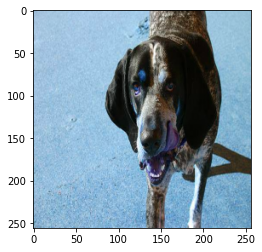

In [14]:
for images,labels in train_dataloader_small:
  plt.imshow(images[0])
  print(labels[0])
  break

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[[0.60784314 0.7254902  0.83137255]
  [0.62745098 0.74509804 0.85098039]
  [0.62745098 0.74509804 0.85098039]
  ...
  [0.56862745 0.72941176 0.81960784]
  [0.56862745 0.72941176 0.81960784]
  [0.56862745 0.72941176 0.81960784]]

 [[0.60784314 0.7254902  0.83137255]
  [0.61960784 0.7372549  0.84313725]
  [0.61568627 0.73333333 0.83921569]
  ...
  [0.56862745 0.72941176 0.81960784]
  [0.56862745 0.72941176 0.81960784]
  [0.56862745 0.72941176 0.81960784]]

 [[0.61960784 0.7372549  0.84313725]
  [0.61568627 0.73333333 0.83921569]
  [0.60784314 0.7254902  0.83137255]
  ...
  [0.56862745 0.72941176 0.81960784]
  [0.56862745 0.7294

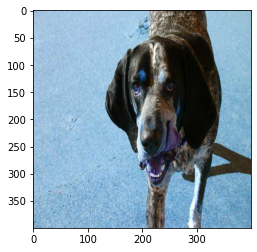

In [15]:
for images,labels in train_dataloader:
  plt.imshow(images[0])
  print(labels[0])
  print(images[0])
  break

**Basic Model using Pretrained Inception Module with a trainable 2 Fully connected layers with 1024 and 120 units.Using image size as 256,256**

In [16]:
np.random.seed(42)
tf.random.set_seed(32)
random.seed(12)

def inception_model(input_shape = (256,256,3),dropout=0):
  '''Creates a simple inception model with 2 fully connected layers'''
  inception = InceptionV3(include_top=False,input_shape=input_shape)
  inception.trainable = False

  model = Sequential()
  model.add(inception)
  model.add(GlobalAveragePooling2D())
  if(dropout != 0):
    model.add(Dropout(0.3))
  model.add(Dense(1024,activation='relu',kernel_initializer='he_uniform'))
  if(dropout != 0):
    model.add(Dropout(0.5))
  model.add(Dense(120,activation='softmax'))
  return model

In [17]:
base_model_1 = inception_model()

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 120)               123000    
                                                                 
Total params: 24,023,960
Trainable params: 2,221,176
Non-trainable params: 21,802,784
_________________________________________________________________


**Creating a helper functions to find learning rate for model and to save best model and metrics**

In [18]:
'''Callback to get learning rate range'''

lr= []
losses = []

'''Custom call back for getting our learning rate range'''
class metricCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,train_data,validation_data,total_epoch,batch_size):
        self.train_data = train_data
        self.test_data = validation_data
 
        self.batch_size = batch_size
        self.total_epoch = total_epoch


    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        
        self.history={'loss': [],'acc': [],'val_loss': [],'val_acc': [],'AUC':[],'val_AUC':[]}
        
    def on_epoch_end(self, epoch, logs={}):
        pass
    def on_batch_begin(self,batch,logs):
      
        pass
        

    def on_batch_end(self,batch,logs):

        '''Here we will try to find out our learning rate range '''
        '''we will try to increase our learning rate slowly after each batch update,
        and will store the loss after each batch along with the learning rate. 
        Plotting these two values will give us an idea about our learning rate'''

        

        global lr
        global losses

        '''getting loss after batch has ended'''
        l = logs['loss']
        '''getting the learning rate corresponding to the loss'''
        lr.append(K.get_value(self.model.optimizer.lr))
        losses.append(l)

        '''we will start from small lr e-10 to e10 and check our plot for these values'''
        start_lr = 0.0000000001
        end_lr = 10

        '''Number of batch updates in each epoch'''
        step_size = len(self.train_data)
        '''total batch updates across all epochs'''
        iter = (self.total_epoch*step_size)
        '''used to increase our lr exponentialy'''
        LRmult = (end_lr/start_lr)**(1/iter)
        '''calculating new lr'''
        new_lr = K.get_value(self.model.optimizer.lr)*LRmult
        '''setting new lr for our next batch'''
        K.set_value(self.model.optimizer.lr, new_lr)
        #print('lr:',K.get_value(self.model.optimizer.lr))
        
     
        
       

    


def lr_range(model,batch_size):

  '''This function plots the train loss after each batch for 3 epochs to get a good learning
  rate for our model'''

  lr.clear()
  losses.clear()

  '''Defining callback'''
  nb_epoch = 3
  f1_callback=metricCallback(train_dataloader,test_dataloader,nb_epoch,batch_size)

  '''running for 3 epochs'''
  optimizer = Adam(0.0000000001)
  model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  model.fit(train_dataloader,epochs = 3,steps_per_epoch = len(train_dataloader),
                validation_data=test_dataloader,callbacks =[f1_callback])


  '''Plotting the losses'''
  plt.plot(lr, losses)
  plt.xscale("log")
  plt.xlabel("Learning Rate (Log Scale)")
  plt.ylabel("Loss")
  plt.show()




def conf_callbacks(save_model,log_name,reduce_lr=True):

  '''This function creates callbacks for our model chekcpoint and csvlogger'''

  '''model checkpoint'''
  file_path = os.path.join(os.getcwd(),'drive','MyDrive',save_model)
  checkpoint = ModelCheckpoint(file_path,save_best_only=True,monitor='val_loss')

  '''csv logger'''
  csvlogger = CSVLogger(os.path.join(os.getcwd(),'drive','MyDrive',log_name))   


  '''lr reducer reduce lr by 20%'''
  lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3,min_lr=1e-5)


  callbacks = [checkpoint,csvlogger]
  if(reduce_lr):
    callbacks = [checkpoint,csvlogger,lr_reducer]

  return callbacks



def plot_loss(log_name,index):

  '''Plots the training and validation loss over epochs reading the logs file'''
  loss = []
  val_loss = []
  epochs = []
  for i in range(1,index+1):
    logs = pd.read_csv(os.path.join(os.getcwd(),'drive','MyDrive',log_name+str(i)+'.log'))
    loss += (list(logs['loss'].values))
    val_loss += (list(logs['val_loss'].values))
    epochs += (list(logs['epoch'].values))

  epo = []
  for i in range(len(epochs)):
    epo.append(i)



  plt.plot(epo,loss,label='loss')
  plt.plot(epo,val_loss,label='val_loss')
  plt.title('loss vs val_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

**Seeing the below plot we can see that out model is learning between 1e-5 and 3e-3. i am going to start with 3e-3 and reduce my lr**

Epoch 1/3
143/143 [==============================] - 91s 607ms/step - loss: 5.1234 - accuracy: 0.0083 - val_loss: 5.0817 - val_accuracy: 0.0115
Epoch 2/3
143/143 [==============================] - 84s 589ms/step - loss: 4.6158 - accuracy: 0.0733 - val_loss: 2.2210 - val_accuracy: 0.4656
Epoch 3/3
143/143 [==============================] - 84s 586ms/step - loss: 9.1731 - accuracy: 0.0798 - val_loss: 12.4255 - val_accuracy: 0.0073


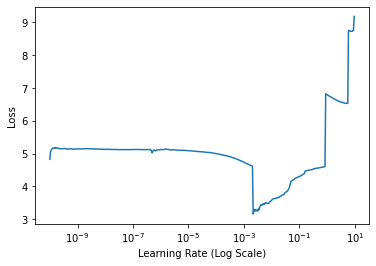

In [ ]:
'''Getting the learnin grate range for model 1'''
lr_range(base_model_1,64)

**Running basic model for 2 epochs and seeing the batch wise train and validation loss. Running the model on 100 data points and we can see the model overfitting with training loss reaching 2e-4.**

In [ ]:
optimizer = Adam()
test_model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
test_model.fit(train_dataloader_small,epochs = 60,batch_size = 32,steps_per_epoch = len(train_dataloader_small),
               validation_data=test_dataloader_small)

Epoch 1/60
3/3 [==============================] - 10s 2s/step - loss: 11.5071 - accuracy: 0.3854 - val_loss: 45.3854 - val_accuracy: 0.0417
Epoch 2/60
3/3 [==============================] - 4s 1s/step - loss: 14.6638 - accuracy: 0.3542 - val_loss: 52.6175 - val_accuracy: 0.0000e+00
Epoch 3/60
3/3 [==============================] - 4s 1s/step - loss: 12.1404 - accuracy: 0.4896 - val_loss: 49.0859 - val_accuracy: 0.0104
Epoch 4/60
3/3 [==============================] - 4s 2s/step - loss: 10.7651 - accuracy: 0.6458 - val_loss: 46.3196 - val_accuracy: 0.0208
Epoch 5/60
3/3 [==============================] - 4s 1s/step - loss: 9.5154 - accuracy: 0.5938 - val_loss: 46.1299 - val_accuracy: 0.0104
Epoch 6/60
3/3 [==============================] - 4s 1s/step - loss: 8.8126 - accuracy: 0.6354 - val_loss: 42.6905 - val_accuracy: 0.0312
Epoch 7/60
3/3 [==============================] - 4s 1s/step - loss: 6.6755 - accuracy: 0.6979 - val_loss: 37.8777 - val_accuracy: 0.0104
Epoch 8/60
3/3 [=========

**Training on whole dataset**

In [ ]:
base_model_1 = inception_model()

optimizer = Adam(0.003)
callbacks = conf_callbacks('dog_incep_model_1','training_1_1.log')
base_model_1.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_1.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 129s 878ms/step - loss: 3.5053 - accuracy: 0.2544 - val_loss: 1.4045 - val_accuracy: 0.5844 - lr: 0.0030
Epoch 2/20
143/143 [==============================] - 125s 876ms/step - loss: 2.3216 - accuracy: 0.3988 - val_loss: 1.2429 - val_accuracy: 0.6250 - lr: 0.0030
Epoch 3/20
143/143 [==============================] - 129s 903ms/step - loss: 2.1472 - accuracy: 0.4421 - val_loss: 1.1778 - val_accuracy: 0.6448 - lr: 0.0030
Epoch 4/20
143/143 [==============================] - 125s 875ms/step - loss: 2.0524 - accuracy: 0.4574 - val_loss: 1.1669 - val_accuracy: 0.6469 - lr: 0.0030
Epoch 5/20
143/143 [==============================] - 84s 583ms/step - loss: 1.9942 - accuracy: 0.4701 - val_loss: 1.2040 - val_accuracy: 0.6510 - lr: 0.0030
Epoch 6/20
143/143 [==============================] - 124s 868ms/step - loss: 1.9420 - accuracy: 0.4845 - val_loss: 1.1235 - val_accuracy: 0.6656 - lr: 0.0030
Epoch 7/20
143/143 [===========================

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1','training_1_2.log')
base_model_1.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 126s 882ms/step - loss: 1.2653 - accuracy: 0.6420 - val_loss: 1.0919 - val_accuracy: 0.7021 - lr: 0.0015
Epoch 2/20
143/143 [==============================] - 84s 588ms/step - loss: 1.2661 - accuracy: 0.6399 - val_loss: 1.0939 - val_accuracy: 0.6833 - lr: 0.0015
Epoch 3/20
143/143 [==============================] - 84s 585ms/step - loss: 1.2055 - accuracy: 0.6579 - val_loss: 1.1475 - val_accuracy: 0.6906 - lr: 0.0015
Epoch 4/20
143/143 [==============================] - 84s 583ms/step - loss: 1.1861 - accuracy: 0.6619 - val_loss: 1.1898 - val_accuracy: 0.6792 - lr: 0.0015
Epoch 5/20
143/143 [==============================] - 84s 584ms/step - loss: 1.1502 - accuracy: 0.6755 - val_loss: 1.1260 - val_accuracy: 0.6917 - lr: 0.0012
Epoch 6/20
143/143 [==============================] - 84s 583ms/step - loss: 1.1085 - accuracy: 0.6879 - val_loss: 1.1529 - val_accuracy: 0.6875 - lr: 0.0012
Epoch 7/20
143/143 [==============================]

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1','training_1_3.log')
base_model_1.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 145s 1s/step - loss: 0.8440 - accuracy: 0.7645 - val_loss: 1.1753 - val_accuracy: 0.7000 - lr: 4.0265e-04
Epoch 2/20
143/143 [==============================] - 83s 576ms/step - loss: 0.8307 - accuracy: 0.7691 - val_loss: 1.1849 - val_accuracy: 0.7063 - lr: 4.0265e-04
Epoch 3/20
143/143 [==============================] - 122s 857ms/step - loss: 0.8047 - accuracy: 0.7791 - val_loss: 1.1721 - val_accuracy: 0.7052 - lr: 4.0265e-04
Epoch 4/20
143/143 [==============================] - 82s 574ms/step - loss: 0.8031 - accuracy: 0.7768 - val_loss: 1.1766 - val_accuracy: 0.7021 - lr: 4.0265e-04
Epoch 5/20
143/143 [==============================] - 82s 572ms/step - loss: 0.7839 - accuracy: 0.7817 - val_loss: 1.1996 - val_accuracy: 0.7010 - lr: 4.0265e-04
Epoch 6/20
143/143 [==============================] - 82s 574ms/step - loss: 0.7945 - accuracy: 0.7807 - val_loss: 1.1945 - val_accuracy: 0.6979 - lr: 4.0265e-04
Epoch 7/20
143/143 [=========

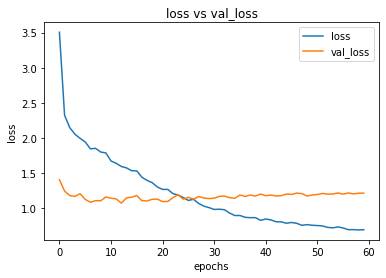

In [ ]:
plot_loss('training_1_',3)

In [ ]:
base_model_1_2 = inception_model()

optimizer = Adam(0.0001)
callbacks = conf_callbacks('dog_incep_model_1_2','training_1_2_1.log',False)
base_model_1_2.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_1_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)


Epoch 1/20
143/143 [==============================] - 127s 863ms/step - loss: 3.9598 - accuracy: 0.1867 - val_loss: 2.0973 - val_accuracy: 0.5583
Epoch 2/20
143/143 [==============================] - 123s 858ms/step - loss: 2.6254 - accuracy: 0.3871 - val_loss: 1.2883 - val_accuracy: 0.6490
Epoch 3/20
143/143 [==============================] - 123s 858ms/step - loss: 2.2920 - accuracy: 0.4280 - val_loss: 1.0986 - val_accuracy: 0.7000
Epoch 4/20
143/143 [==============================] - 125s 875ms/step - loss: 2.0839 - accuracy: 0.4783 - val_loss: 1.0361 - val_accuracy: 0.7021
Epoch 5/20
143/143 [==============================] - 123s 860ms/step - loss: 1.9977 - accuracy: 0.4949 - val_loss: 0.9950 - val_accuracy: 0.6917
Epoch 6/20
143/143 [==============================] - 123s 860ms/step - loss: 1.8723 - accuracy: 0.5186 - val_loss: 0.9675 - val_accuracy: 0.7125
Epoch 7/20
143/143 [==============================] - 122s 856ms/step - loss: 1.8340 - accuracy: 0.5282 - val_loss: 0.9394 -

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1_2','training_1_2_2.log',False)
base_model_1_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader)

Epoch 1/20
143/143 [==============================] - 83s 576ms/step - loss: 1.3351 - accuracy: 0.6475 - val_loss: 0.8652 - val_accuracy: 0.7531
Epoch 2/20
143/143 [==============================] - 83s 578ms/step - loss: 1.2876 - accuracy: 0.6595 - val_loss: 0.8877 - val_accuracy: 0.7437
Epoch 3/20
143/143 [==============================] - 82s 573ms/step - loss: 1.2816 - accuracy: 0.6549 - val_loss: 0.8892 - val_accuracy: 0.7240
Epoch 4/20
143/143 [==============================] - 82s 571ms/step - loss: 1.2684 - accuracy: 0.6636 - val_loss: 0.8964 - val_accuracy: 0.7260
Epoch 5/20
143/143 [==============================] - 82s 574ms/step - loss: 1.2525 - accuracy: 0.6731 - val_loss: 0.8847 - val_accuracy: 0.7385
Epoch 6/20
143/143 [==============================] - 82s 576ms/step - loss: 1.2053 - accuracy: 0.6779 - val_loss: 0.8792 - val_accuracy: 0.7396
Epoch 7/20
143/143 [==============================] - 83s 578ms/step - loss: 1.1972 - accuracy: 0.6813 - val_loss: 0.8931 - val_ac

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1_2','training_1_2_3.log',False)
base_model_1_2.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader)

Epoch 1/10
143/143 [==============================] - 83s 580ms/step - loss: 0.9636 - accuracy: 0.7463 - val_loss: 0.9167 - val_accuracy: 0.7354
Epoch 2/10
143/143 [==============================] - 83s 577ms/step - loss: 0.9619 - accuracy: 0.7490 - val_loss: 0.9220 - val_accuracy: 0.7250
Epoch 3/10
143/143 [==============================] - 83s 580ms/step - loss: 0.9374 - accuracy: 0.7485 - val_loss: 0.9006 - val_accuracy: 0.7448
Epoch 4/10
143/143 [==============================] - 83s 579ms/step - loss: 0.9258 - accuracy: 0.7631 - val_loss: 0.9286 - val_accuracy: 0.7365
Epoch 5/10
143/143 [==============================] - 83s 581ms/step - loss: 0.9229 - accuracy: 0.7591 - val_loss: 0.9063 - val_accuracy: 0.7375
Epoch 6/10
143/143 [==============================] - 82s 575ms/step - loss: 0.8809 - accuracy: 0.7737 - val_loss: 0.9099 - val_accuracy: 0.7427
Epoch 7/10
143/143 [==============================] - 83s 577ms/step - loss: 0.8824 - accuracy: 0.7716 - val_loss: 0.9118 - val_ac

**Model 1 with different image size**

In [ ]:
base_model_1_400 = inception_model((400,400,3),0.3)
optim = Adam()
callbacks = conf_callbacks('dog_incep_model_1_400_1','training_400_1.log',False)
base_model_1_400.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_1_400.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 204s 689ms/step - loss: 4.1825 - accuracy: 0.0840 - val_loss: 2.4446 - val_accuracy: 0.4657
Epoch 2/20
287/287 [==============================] - 163s 567ms/step - loss: 3.2874 - accuracy: 0.1884 - val_loss: 1.7573 - val_accuracy: 0.6038
Epoch 3/20
287/287 [==============================] - 163s 568ms/step - loss: 3.0130 - accuracy: 0.2311 - val_loss: 1.4370 - val_accuracy: 0.6754
Epoch 4/20
287/287 [==============================] - 164s 570ms/step - loss: 2.8454 - accuracy: 0.2656 - val_loss: 1.2380 - val_accuracy: 0.6815
Epoch 5/20
287/287 [==============================] - 162s 564ms/step - loss: 2.7563 - accuracy: 0.2807 - val_loss: 1.1465 - val_accuracy: 0.7016
Epoch 6/20
287/287 [==============================] - 164s 571ms/step - loss: 2.6538 - accuracy: 0.3061 - val_loss: 1.0859 - val_accuracy: 0.7167
Epoch 7/20
287/287 [==============================] - 161s 561ms/step - loss: 2.6378 - accuracy: 0.3161 - val_loss: 1.0035 -

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1_400_1','training_400_2.log',False)
base_model_1_400.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 159s 553ms/step - loss: 2.3108 - accuracy: 0.3806 - val_loss: 0.8097 - val_accuracy: 0.7470
Epoch 2/20
287/287 [==============================] - 117s 408ms/step - loss: 2.3312 - accuracy: 0.3787 - val_loss: 0.8119 - val_accuracy: 0.7611
Epoch 3/20
287/287 [==============================] - 158s 552ms/step - loss: 2.2742 - accuracy: 0.3951 - val_loss: 0.7911 - val_accuracy: 0.7571
Epoch 4/20
287/287 [==============================] - 117s 408ms/step - loss: 2.3199 - accuracy: 0.3824 - val_loss: 0.7985 - val_accuracy: 0.7550
Epoch 5/20
287/287 [==============================] - 117s 406ms/step - loss: 2.2839 - accuracy: 0.3862 - val_loss: 0.8090 - val_accuracy: 0.7500
Epoch 6/20
287/287 [==============================] - 117s 407ms/step - loss: 2.3085 - accuracy: 0.3855 - val_loss: 0.8036 - val_accuracy: 0.7581
Epoch 7/20
287/287 [==============================] - 160s 558ms/step - loss: 2.2620 - accuracy: 0.3981 - val_loss: 0.7806 -

In [ ]:
callbacks = conf_callbacks('dog_incep_model_1_400_1','training_400_3.log',False)
base_model_1_400.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 160s 557ms/step - loss: 2.2034 - accuracy: 0.4070 - val_loss: 0.7356 - val_accuracy: 0.7722
Epoch 2/20
287/287 [==============================] - 159s 553ms/step - loss: 2.2232 - accuracy: 0.4033 - val_loss: 0.7265 - val_accuracy: 0.7762
Epoch 3/20
287/287 [==============================] - 116s 404ms/step - loss: 2.1910 - accuracy: 0.4181 - val_loss: 0.7668 - val_accuracy: 0.7571
Epoch 4/20
287/287 [==============================] - 118s 410ms/step - loss: 2.2289 - accuracy: 0.4056 - val_loss: 0.7484 - val_accuracy: 0.7692
Epoch 5/20
287/287 [==============================] - 117s 409ms/step - loss: 2.2108 - accuracy: 0.4106 - val_loss: 0.7759 - val_accuracy: 0.7611
Epoch 6/20
287/287 [==============================] - 118s 411ms/step - loss: 2.2162 - accuracy: 0.4098 - val_loss: 0.7373 - val_accuracy: 0.7722
Epoch 7/20
287/287 [==============================] - 118s 411ms/step - loss: 2.2276 - accuracy: 0.4100 - val_loss: 0.7427 -

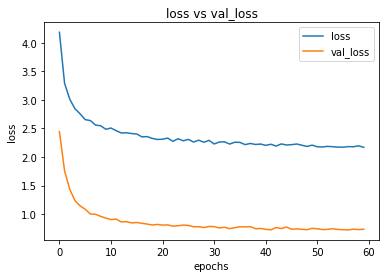

In [ ]:
plot_loss('training_400_',3)

**SUMMARY FOR MODEL 1**

1. 1st training was done on basic model with lr of 0.001 with image size of 256*256 and i got val score of 1.12

2. 2nd training was done on basic model with lr of 0.0001 with image size of 256*256 and i got val score of 0.87

3. 3rd training was done on basic model with lr of 0.001 with image size of 400*400 and i got val score of 0.74

In [ ]:
base_model_1_400_2 = inception_model((400,400,3),0.3)
optim = Adam(0.0001)
callbacks = conf_callbacks('dog_incep_model_1_400_2','training_400_1_1.log',False)
base_model_1_400_2.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_1_400_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 168s 572ms/step - loss: 4.3373 - accuracy: 0.0641 - val_loss: 2.9147 - val_accuracy: 0.3639
Epoch 2/20
287/287 [==============================] - 163s 568ms/step - loss: 3.5081 - accuracy: 0.1433 - val_loss: 2.0923 - val_accuracy: 0.5444
Epoch 3/20
287/287 [==============================] - 163s 569ms/step - loss: 3.2098 - accuracy: 0.1902 - val_loss: 1.6746 - val_accuracy: 0.6240
Epoch 4/20
287/287 [==============================] - 163s 568ms/step - loss: 3.0305 - accuracy: 0.2225 - val_loss: 1.4615 - val_accuracy: 0.6522
Epoch 5/20
287/287 [==============================] - 165s 574ms/step - loss: 2.8932 - accuracy: 0.2503 - val_loss: 1.3145 - val_accuracy: 0.6915
Epoch 6/20
287/287 [==============================] - 161s 561ms/step - loss: 2.8493 - accuracy: 0.2644 - val_loss: 1.2899 - val_accuracy: 0.7016
Epoch 7/20
287/287 [==============================] - 163s 568ms/step - loss: 2.8289 - accuracy: 0.2637 - val_loss: 1.2058 -

**Inception model 2 with additional layers total of 3 FC layers with 1024,512,256 activations with softmax**

In [19]:
def inception_model_2(input_shape=(256,256,3)):
  '''Creates a simple inception model with 2 fully connected layers'''
  inception = InceptionV3(include_top=False,input_shape=input_shape)
  inception.trainable = False

  model = Sequential()
  model.add(inception)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1024,activation='relu',kernel_initializer='he_uniform'))
  
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))

  model.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dense(120,activation='softmax'))
  return model

In [20]:
base_model_2 = inception_model_2()
base_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 120)               30840     
                                                      

Epoch 1/3
143/143 [==============================] - 71s 459ms/step - loss: 5.4402 - accuracy: 0.0073 - val_loss: 4.8760 - val_accuracy: 0.0083
Epoch 2/3
143/143 [==============================] - 64s 449ms/step - loss: 5.3730 - accuracy: 0.0080 - val_loss: 4.8875 - val_accuracy: 0.0135
Epoch 3/3
143/143 [==============================] - 64s 447ms/step - loss: 5.3146 - accuracy: 0.0084 - val_loss: 9.7403 - val_accuracy: 0.0094


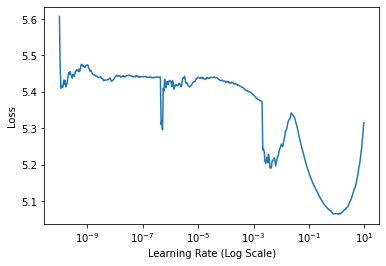

In [ ]:
lr_range(base_model_2,64)

**Looking at abov eplot we could select 0.001 or 0.1 . I will start with 0.001 and see the results**

In [ ]:
callbacks = conf_callbacks('dog_base_inception_2','training_2_1.log')

In [ ]:
optimizer = Adam()
callbacks = conf_callbacks('dog_base_inception_2','training_2_1.log',False)
base_model_2 = inception_model_2()
base_model_2.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/20
287/287 [==============================] - 242s 780ms/step - loss: 3.4997 - accuracy: 0.1969 - val_loss: 1.4830 - val_accuracy: 0.5312
Epoch 2/20
287/287 [==============================] - 222s 772ms/step - loss: 2.1186 - accuracy: 0.4261 - val_loss: 1.0442 - val_accuracy: 0.6633
Epoch 3/20
287/287 [==============================] - 234s 814ms/step - loss: 1.8663 - accuracy: 0.4801 - val_loss: 0.9940 - val_accuracy: 0.6865
Epoch 4/20
287/287 [==============================] - 232s 809ms/step - loss: 1.7580 - accuracy: 0.5090 - val_loss: 0.8129 - val_accuracy: 0.7379
Epoch 5/20
287/287 [==============================] - 174s 605ms/step - loss: 1.6758 - accuracy: 0.5335 - val_loss: 0.8217 - val_accuracy: 0.7409
Epoch 6/20
287/287 [==============================] - 174s 604ms/step - loss: 1.5807 - accuracy: 0.5537 - val_loss: 0.8248 - val_accuracy: 0.7450
Epoch 7/20
287/287 [==============================] - 236s 

In [ ]:
callbacks = conf_callbacks('dog_base_inception_2','training_2_2.log',False)
base_model_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 236s 821ms/step - loss: 1.1132 - accuracy: 0.6769 - val_loss: 0.7615 - val_accuracy: 0.7843
Epoch 2/20
287/287 [==============================] - 235s 816ms/step - loss: 1.0829 - accuracy: 0.6840 - val_loss: 0.7200 - val_accuracy: 0.8014
Epoch 3/20
287/287 [==============================] - 178s 619ms/step - loss: 1.0438 - accuracy: 0.6927 - val_loss: 0.7811 - val_accuracy: 0.7762
Epoch 4/20
287/287 [==============================] - 176s 610ms/step - loss: 1.0500 - accuracy: 0.6963 - val_loss: 0.7340 - val_accuracy: 0.7893
Epoch 5/20
287/287 [==============================] - 238s 827ms/step - loss: 1.0010 - accuracy: 0.7020 - val_loss: 0.7035 - val_accuracy: 0.8054
Epoch 6/20
287/287 [==============================] - 181s 631ms/step - loss: 0.9860 - accuracy: 0.7096 - val_loss: 0.7572 - val_accuracy: 0.7812
Epoch 7/20
287/287 [==============================] - 172s 596ms/step - loss: 0.9683 - accuracy: 0.7198 - val_loss: 0.7641 -

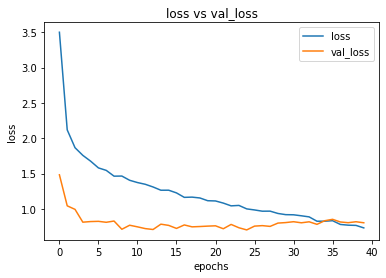

In [ ]:
plot_loss('training_2_',2)

In [ ]:
callbacks = conf_callbacks('dog_base_inception_2','training_2_3.log',False)
base_model_2.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
287/287 [==============================] - 229s 799ms/step - loss: 0.7294 - accuracy: 0.7829 - val_loss: 0.8783 - val_accuracy: 0.7954
Epoch 2/20
287/287 [==============================] - 228s 794ms/step - loss: 0.7312 - accuracy: 0.7823 - val_loss: 0.8265 - val_accuracy: 0.7913
Epoch 3/20
287/287 [==============================] - 179s 621ms/step - loss: 0.6708 - accuracy: 0.7975 - val_loss: 0.8721 - val_accuracy: 0.8014
Epoch 4/20
287/287 [==============================] - 177s 616ms/step - loss: 0.6623 - accuracy: 0.7985 - val_loss: 0.8822 - val_accuracy: 0.7944
Epoch 5/20
287/287 [==============================] - 176s 614ms/step - loss: 0.6679 - accuracy: 0.7973 - val_loss: 0.9044 - val_accuracy: 0.7913
Epoch 6/20
287/287 [==============================] - 176s 613ms/step - loss: 0.6720 - accuracy: 0.7971 - val_loss: 0.9205 - val_accuracy: 0.7883
Epoch 7/20
287/287 [==============================] - 177s 616ms/step - loss: 0.6405 - accuracy: 0.8104 - val_loss: 0.9326 -

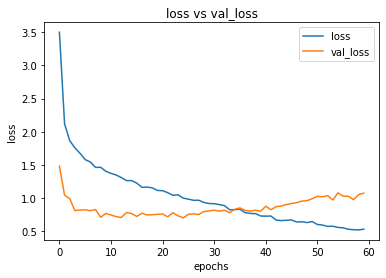

In [ ]:
plot_loss('training_2_',3)

**Looking above plot our val loss looking to pleatue , indicating model i snot learning much after 60 epochs.**

**SUMMARY FOR MODEL 2**

1. I Trained the model 2 with initial lr of 0.001 with image size of 400*400 and got val score of 0.70

**Model 1 training loss is reducing , but val loss is not reducing for 80 epochs**

**Model 3 now where i will be training with 2 FC layers each with 512 units,along with dropout with 0.5. Output from inception model is flattened.**

In [21]:
def inception_model_3():
  '''Creates a simple inception model with 2 fully connected layers'''
  inception = InceptionV3(include_top=False,input_shape=(256,256,3))
  inception.trainable = False

  model = Sequential()
  model.add(inception)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(120,activation='softmax'))
  return model




In [ ]:
base_model_3 = inception_model_3()
base_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 batch_normalization_379 (Ba  (None, 73728)            294912    
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 73728)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               37749248  
                                                                 
 batch_normalization_380 (Ba  (None, 512)              2048      
 tchNormalization)                                    

In [ ]:

optimizer = RMSprop(0.0001)
callbacks = conf_callbacks('dog_base_inception_3','training_4.log')
base_model_3.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_3.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 113s 764ms/step - loss: 6.0649 - accuracy: 0.0093 - val_loss: 5.3815 - val_accuracy: 0.0146
Epoch 2/20
143/143 [==============================] - 108s 758ms/step - loss: 5.8070 - accuracy: 0.0142 - val_loss: 4.9326 - val_accuracy: 0.0146
Epoch 3/20
143/143 [==============================] - 109s 764ms/step - loss: 5.7098 - accuracy: 0.0138 - val_loss: 4.7955 - val_accuracy: 0.0177
Epoch 4/20
143/143 [==============================] - 108s 759ms/step - loss: 5.6296 - accuracy: 0.0142 - val_loss: 4.7569 - val_accuracy: 0.0292
Epoch 5/20
143/143 [==============================] - 110s 768ms/step - loss: 5.5203 - accuracy: 0.0174 - val_loss: 4.7111 - val_accuracy: 0.0208
Epoch 6/20
143/143 [==============================] - 109s 763ms/step - loss: 5.4653 - accuracy: 0.0179 - val_loss: 4.7019 - val_accuracy: 0.0365
Epoch 7/20
143/143 [==============================] - 110s 767ms/step - loss: 5.4094 - accuracy: 0.0203 - val_loss: 4.6662 -

In [ ]:
optimizer = RMSprop(0.0001)
base_model_3 = inception_model_3()
callbacks = conf_callbacks('dog_base_inception_3','training_4_2.log')
base_model_3.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_3.load_weights(os.path.join(os.getcwd(),'drive','MyDrive','dog_base_inception_3'))
base_model_3.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 121s 749ms/step - loss: 4.7869 - accuracy: 0.0415 - val_loss: 4.4159 - val_accuracy: 0.0521
Epoch 2/20
143/143 [==============================] - 107s 748ms/step - loss: 4.7480 - accuracy: 0.0416 - val_loss: 4.4151 - val_accuracy: 0.0562
Epoch 3/20
143/143 [==============================] - 65s 455ms/step - loss: 4.7319 - accuracy: 0.0459 - val_loss: 4.4287 - val_accuracy: 0.0490
Epoch 4/20
143/143 [==============================] - 64s 450ms/step - loss: 4.7017 - accuracy: 0.0457 - val_loss: 4.4256 - val_accuracy: 0.0573
Epoch 5/20
143/143 [==============================] - 65s 451ms/step - loss: 4.6536 - accuracy: 0.0467 - val_loss: 4.4363 - val_accuracy: 0.0437
Epoch 6/20
143/143 [==============================] - 66s 460ms/step - loss: 4.6443 - accuracy: 0.0494 - val_loss: 4.4383 - val_accuracy: 0.0448
Epoch 7/20
143/143 [==============================] - 65s 453ms/step - loss: 4.6038 - accuracy: 0.0507 - val_loss: 4.4296 - val_

In [ ]:
callbacks = conf_callbacks('dog_base_inception_3','training_4_3.log')
base_model_3.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 108s 755ms/step - loss: 4.2941 - accuracy: 0.0854 - val_loss: 4.4187 - val_accuracy: 0.0562
Epoch 2/20
143/143 [==============================] - 65s 456ms/step - loss: 4.2679 - accuracy: 0.0853 - val_loss: 4.4230 - val_accuracy: 0.0542
Epoch 3/20
143/143 [==============================] - 65s 455ms/step - loss: 4.2407 - accuracy: 0.0868 - val_loss: 4.4217 - val_accuracy: 0.0583
Epoch 4/20
143/143 [==============================] - 65s 453ms/step - loss: 4.2356 - accuracy: 0.0828 - val_loss: 4.4344 - val_accuracy: 0.0510
Epoch 5/20
143/143 [==============================] - 65s 454ms/step - loss: 4.2058 - accuracy: 0.0942 - val_loss: 4.4300 - val_accuracy: 0.0552
Epoch 6/20
143/143 [==============================] - 107s 752ms/step - loss: 4.1992 - accuracy: 0.0891 - val_loss: 4.4113 - val_accuracy: 0.0521
Epoch 7/20
143/143 [==============================] - 66s 461ms/step - loss: 4.1810 - accuracy: 0.0919 - val_loss: 4.4308 - val_

In [ ]:
callbacks = conf_callbacks('dog_base_inception_3','training_4_4.log')
base_model_3.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
143/143 [==============================] - 108s 754ms/step - loss: 3.9032 - accuracy: 0.1316 - val_loss: 4.4266 - val_accuracy: 0.0688
Epoch 2/20
143/143 [==============================] - 72s 505ms/step - loss: 3.8563 - accuracy: 0.1453 - val_loss: 4.4308 - val_accuracy: 0.0594
Epoch 3/20
143/143 [==============================] - 68s 477ms/step - loss: 3.8704 - accuracy: 0.1438 - val_loss: 4.4368 - val_accuracy: 0.0635
Epoch 4/20
143/143 [==============================] - 65s 451ms/step - loss: 3.8265 - accuracy: 0.1489 - val_loss: 4.4346 - val_accuracy: 0.0552
Epoch 5/20
143/143 [==============================] - 108s 754ms/step - loss: 3.8070 - accuracy: 0.1547 - val_loss: 4.4137 - val_accuracy: 0.0573
Epoch 6/20
143/143 [==============================] - 114s 795ms/step - loss: 3.7827 - accuracy: 0.1615 - val_loss: 4.4097 - val_accuracy: 0.0677
Epoch 7/20
143/143 [==============================] - 115s 803ms/step - loss: 3.7680 - accuracy: 0.1579 - val_loss: 4.4025 - va

In [ ]:
callbacks = conf_callbacks('dog_base_inception_3','training_4_5.log')
base_model_3.fit(train_dataloader,epochs = 50,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/50
143/143 [==============================] - 114s 796ms/step - loss: 3.4876 - accuracy: 0.2097 - val_loss: 4.4289 - val_accuracy: 0.0594
Epoch 2/50
143/143 [==============================] - 66s 462ms/step - loss: 3.4603 - accuracy: 0.2185 - val_loss: 4.4402 - val_accuracy: 0.0625
Epoch 3/50
143/143 [==============================] - 108s 758ms/step - loss: 3.4542 - accuracy: 0.2232 - val_loss: 4.4260 - val_accuracy: 0.0615
Epoch 4/50
143/143 [==============================] - 109s 764ms/step - loss: 3.4476 - accuracy: 0.2232 - val_loss: 4.4147 - val_accuracy: 0.0615
Epoch 5/50
143/143 [==============================] - 73s 511ms/step - loss: 3.4107 - accuracy: 0.2244 - val_loss: 4.4317 - val_accuracy: 0.0531
Epoch 6/50
143/143 [==============================] - 71s 495ms/step - loss: 3.3985 - accuracy: 0.2296 - val_loss: 4.4442 - val_accuracy: 0.0510
Epoch 7/50
143/143 [==============================] - 69s 483ms/step - loss: 3.3793 - accuracy: 0.2383 - val_loss: 4.4346 - val

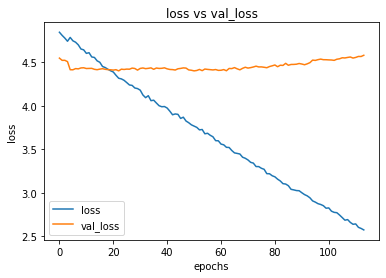

In [ ]:
logs = pd.read_csv(os.path.join(os.getcwd(),'drive','MyDrive','training_4.log'))
loss = list(logs['loss'].values)
val_loss = list(logs['val_loss'].values)
epochs = list(logs['epoch'].values)

for i in range(2,6):
  logs = pd.read_csv(os.path.join(os.getcwd(),'drive','MyDrive','training_4_'+str(i)+'.log'))
  loss += (list(logs['loss'].values))
  val_loss += (list(logs['val_loss'].values))
  epochs += (list(logs['epoch'].values))

epo = []
for i in range(len(epochs)):
  epo.append(i)



plt.plot(epo,loss,label='loss')
plt.plot(epo,val_loss,label='val_loss')
plt.title('loss vs val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


**Our inception model 3 is haevily overfitting as we can see in the plot, May be our trainable parameters are large,Lets check model 2 which has less parameters and see the results**

**Inception with resnet verion 2**

In [9]:
def inception_resnet_model(input_shape=(256,256,3),dropout=0):
  inception_resnet = InceptionResNetV2(include_top=False,input_shape=input_shape)
  inception_resnet.trainable = False

  model = Sequential()
  model.add(inception_resnet)

  model.add(GlobalAveragePooling2D())
  if(dropout!=0):
    model.add(Dropout(0.3))
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
  if(dropout!=0):
    model.add(Dropout(0.3))
  model.add(Dense(120,activation='softmax'))

  return model



In [ ]:
base_model_4 = inception_resnet_model((350,350,3))
base_model_4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 512)               786944    
                                                                 
 dense_16 (Dense)            (None, 120)               61560     
                                                                 
Total params: 55,185,240
Trainable params: 848,504
Non-trainable params: 54,336,736
_________________________________________________________________


**Training without augmentation batch size= 16 image size=400**

In [ ]:
'''training without augmentation
batch = 16
Model is overfittig'''

base_model_4 = inception_resnet_model((350,350,3))
callbacks = conf_callbacks('dog_inception_resnet_1','training_4_1.log')
base_model_4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
base_model_4.fit(train_dataloader,epochs = 20,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/20
574/574 [==============================] - 472s 797ms/step - loss: 1.0643 - accuracy: 0.7247 - val_loss: 0.7556 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 2/20
574/574 [==============================] - 459s 799ms/step - loss: 0.5603 - accuracy: 0.8212 - val_loss: 0.7542 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 3/20
574/574 [==============================] - 459s 799ms/step - loss: 0.4709 - accuracy: 0.8498 - val_loss: 0.6931 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 4/20
574/574 [==============================] - 456s 795ms/step - loss: 0.4075 - accuracy: 0.8660 - val_loss: 0.6830 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 5/20
574/574 [==============================] - 324s 564ms/step - loss: 0.3513 - accuracy: 0.8841 - val_loss: 0.7170 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 6/20
574/574 [==============================] - 324s 563ms/step - loss: 0.3145 - accuracy: 0.8923 - val_loss: 0.7717 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 7/20
574/574 [==========================

KeyboardInterrupt: ignored

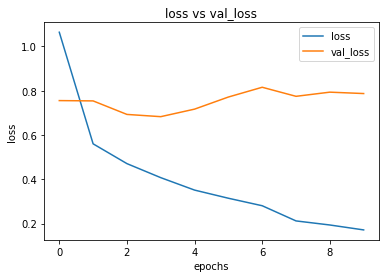

In [ ]:
plot_loss('training_4_',1)

**The model was overfitting as seen in the above plot**

**Trying the same model without augmentation with batch size= 32 and with drop outs to reduce overfitting**

In [ ]:
'''training without augmentation
batch = 32 image: 400
with dropouts
'''

base_model_6 = inception_resnet_model((350,350,3),0.3)
callbacks = conf_callbacks('dog_inception_resnet_3','training_6_1.log')
base_model_6.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
base_model_6.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/10
287/287 [==============================] - 572s 2s/step - loss: 1.4720 - accuracy: 0.6649 - val_loss: 0.6080 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 2/10
287/287 [==============================] - 543s 2s/step - loss: 0.6079 - accuracy: 0.8173 - val_loss: 0.5580 - val_accuracy: 0.8226 - lr: 0.0010
Epoch 3/10
287/287 [==============================] - 543s 2s/step - loss: 0.5229 - accuracy: 0.8370 - val_loss: 0.5368 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 4/10
287/287 [==============================] - 545s 2s/step - loss: 0.4677 - accuracy: 0.8490 - val_loss: 0.5332 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 5/10
287/287 [==============================] - 416s 1s/step - loss: 0.4261 - accuracy: 0.8583 - val_loss: 0.5533 - val_accuracy: 0.8397 - lr: 0.0010
Epoch 6/10
287/287 [==============================] - 415s 1s/step - loss: 0.4096 - accuracy: 0.8633 - val_loss: 0.5354 - val_accuracy: 0.8458 - lr: 0.00

In [ ]:
K.set_value(base_model_6.optimizer.lr,0.0005)
callbacks = conf_callbacks('dog_inception_resnet_3','training_6_2.log')
base_model_6.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/10
287/287 [==============================] - 559s 2s/step - loss: 0.2494 - accuracy: 0.9131 - val_loss: 0.5037 - val_accuracy: 0.8659 - lr: 5.0000e-04
Epoch 2/10
287/287 [==============================] - 416s 1s/step - loss: 0.2377 - accuracy: 0.9174 - val_loss: 0.5106 - val_accuracy: 0.8599 - lr: 5.0000e-04
Epoch 3/10
287/287 [==============================] - 415s 1s/step - loss: 0.2346 - accuracy: 0.9196 - val_loss: 0.5065 - val_accuracy: 0.8639 - lr: 5.0000e-04
Epoch 4/10
287/287 [==============================] - 415s 1s/step - loss: 0.2191 - accuracy: 0.9218 - val_loss: 0.5177 - val_accuracy: 0.8548 - lr: 5.0000e-04
Epoch 5/10
287/287 [==============================] - 416s 1s/step - loss: 0.2029 - accuracy: 0.9257 - val_loss: 0.5330 - val_accuracy: 0.8589 - lr: 4.0000e-04
Epoch 6/10
287/287 [==============================] - 415s 1s/step - loss: 0.1972 - accuracy: 0.9285 - val_loss: 0.5181 - val_accuracy: 0.8599 - lr: 4.0000e-04
Epoch 7/10
287/287 [====================

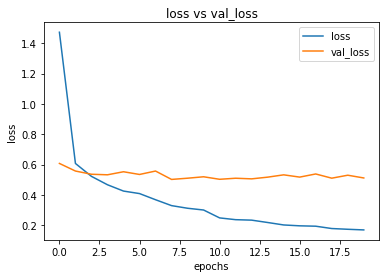

In [ ]:
plot_loss('training_6_',2)

**The model performed well with val_loss of 0.50**

**Trying the same model with augmentation this time**

In [ ]:
'''Trying with augmentation
batch = 32
image = 400*400'''

base_model_5 = inception_resnet_model((400,400,3))
callbacks = conf_callbacks('dog_inception_resnet_2','training_5_1.log')
base_model_5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
base_model_5.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/10
287/287 [==============================] - 549s 2s/step - loss: 2.4741 - accuracy: 0.4538 - val_loss: 0.7948 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 2/10
287/287 [==============================] - 517s 2s/step - loss: 1.4309 - accuracy: 0.6156 - val_loss: 0.6543 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 3/10
287/287 [==============================] - 519s 2s/step - loss: 1.2808 - accuracy: 0.6414 - val_loss: 0.6070 - val_accuracy: 0.8145 - lr: 0.0010
Epoch 4/10
287/287 [==============================] - 520s 2s/step - loss: 1.1901 - accuracy: 0.6630 - val_loss: 0.5503 - val_accuracy: 0.8256 - lr: 0.0010
Epoch 5/10
287/287 [==============================] - 384s 1s/step - loss: 1.1350 - accuracy: 0.6781 - val_loss: 0.5729 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 6/10
287/287 [==============================] - 384s 1s/step - loss: 1.1101 - accuracy: 0.6779 - val_loss: 0.5549 - val_accuracy: 0.8226 - lr: 0.0010
Epoch 7/10
287/287 [==============================] - 384s 1s/st

In [ ]:
callbacks = conf_callbacks('dog_inception_resnet_2','training_5_2.log')
base_model_5.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/10
287/287 [==============================] - 519s 2s/step - loss: 0.9194 - accuracy: 0.7266 - val_loss: 0.5507 - val_accuracy: 0.8155 - lr: 8.0000e-04
Epoch 2/10
287/287 [==============================] - 520s 2s/step - loss: 0.8818 - accuracy: 0.7412 - val_loss: 0.5399 - val_accuracy: 0.8085 - lr: 8.0000e-04
Epoch 3/10
287/287 [==============================] - 519s 2s/step - loss: 0.8455 - accuracy: 0.7459 - val_loss: 0.5270 - val_accuracy: 0.8236 - lr: 8.0000e-04
Epoch 4/10
287/287 [==============================] - 385s 1s/step - loss: 0.8167 - accuracy: 0.7520 - val_loss: 0.5466 - val_accuracy: 0.8196 - lr: 8.0000e-04
Epoch 5/10
287/287 [==============================] - 385s 1s/step - loss: 0.8037 - accuracy: 0.7606 - val_loss: 0.5443 - val_accuracy: 0.8236 - lr: 8.0000e-04
Epoch 6/10
287/287 [==============================] - 389s 1s/step - loss: 0.7925 - accuracy: 0.7600 - val_loss: 0.5339 - val_accuracy: 0.8276 - lr: 8.0000e-04
Epoch 7/10
287/287 [====================

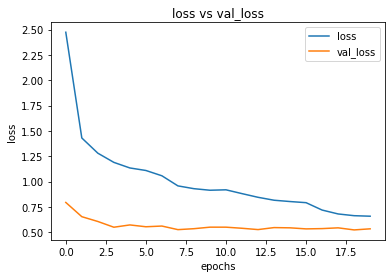

In [ ]:
plot_loss('training_5_',2)

**Not good if we compare to previous model with val_loss of 0.53**

**Trying a new model with inception resnet v2 as backbone and 3 fc layers with units 512,256 and 120**

In [11]:
def inception_resnet_model_2(input_shape=(256,256,3),dropout=0):
  inception_resnet = InceptionResNetV2(include_top=False,input_shape=input_shape)
  inception_resnet.trainable = False

  model = Sequential()
  model.add(inception_resnet)

  model.add(GlobalAveragePooling2D())
  if(dropout!=0):
    model.add(Dropout(0.3))
  model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
  if(dropout!=0):
    model.add(Dropout(0.3))
  model.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
  if(dropout!=0):
    model.add(Dropout(0.3))
  model.add(Dense(120,activation='softmax'))

  return model



**Trying without augmentation with Batch size of 32, image size of 400*400 and learning rate of 0.001**

In [ ]:
'''new front head, without augmentation,  '''
base_model_7 = inception_resnet_model((400,400,3),0.3)
callbacks = conf_callbacks('dog_inception_resnet_4','training_7_1.log')
base_model_7.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
base_model_7.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/10
287/287 [==============================] - 570s 2s/step - loss: 1.4619 - accuracy: 0.6641 - val_loss: 0.6157 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 2/10
287/287 [==============================] - 550s 2s/step - loss: 0.6070 - accuracy: 0.8120 - val_loss: 0.5590 - val_accuracy: 0.8296 - lr: 0.0010
Epoch 3/10
287/287 [==============================] - 555s 2s/step - loss: 0.5181 - accuracy: 0.8355 - val_loss: 0.5360 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 4/10
287/287 [==============================] - 555s 2s/step - loss: 0.4592 - accuracy: 0.8516 - val_loss: 0.5143 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 5/10
287/287 [==============================] - 581s 2s/step - loss: 0.4285 - accuracy: 0.8617 - val_loss: 0.5137 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 6/10
287/287 [==============================] - 417s 1s/step - loss: 0.4002 - accuracy: 0.8686 - val_loss: 0.5512 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 7/10
287/287 [==============================] - 415s 1s/st

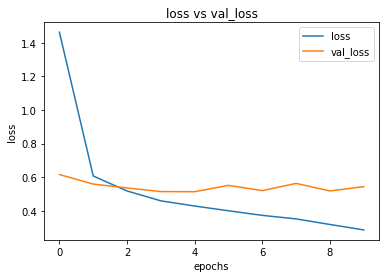

In [ ]:
plot_loss('training_7_',1)

**Val score of 0.51**

**Trying without augmentation with Batch size of 32, image size of 400*400 and learning rate of 0.0001**

In [ ]:
'''new front head, without augmentation, different lr '''
opt = Adam(0.0001)
base_model_7 = inception_resnet_model((400,400,3),0.3)
callbacks = conf_callbacks('dog_inception_resnet_4','training_7_1.log')
base_model_7.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_7.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/10
287/287 [==============================] - 565s 2s/step - loss: 3.9243 - accuracy: 0.3187 - val_loss: 2.5390 - val_accuracy: 0.7621 - lr: 1.0000e-04
Epoch 2/10
287/287 [==============================] - 547s 2s/step - loss: 1.8694 - accuracy: 0.6994 - val_loss: 1.0783 - val_accuracy: 0.8145 - lr: 1.0000e-04
Epoch 3/10
287/287 [==============================] - 547s 2s/step - loss: 1.0381 - accuracy: 0.7771 - val_loss: 0.7292 - val_accuracy: 0.8347 - lr: 1.0000e-04
Epoch 4/10
287/287 [==============================] - 547s 2s/step - loss: 0.7962 - accuracy: 0.7974 - val_loss: 0.6159 - val_accuracy: 0.8357 - lr: 1.0000e-04
Epoch 5/10
287/287 [==============================] - 552s 2s/step - loss: 0.6850 - accuracy: 0.8130 - val_loss: 0.5592 - val_accuracy: 0.8407 - lr: 1.0000e-04
Epoch 6/10
287/287 [==============================] - 553s 2s/step - loss: 0.6227 - accuracy: 0.8275 - val_loss: 0.5236 - val_accuracy: 0.8488 - lr: 1.0000e-04
Epoch 7/10
287/287 [====================

In [ ]:
opt = Adam(0.0001)
base_model_7 = inception_resnet_model((400,400,3),0.3)
callbacks = conf_callbacks('dog_inception_resnet_4','training_7_2.log')
base_model_7.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
base_model_7.load_weights(os.path.join(os.getcwd(),'drive','MyDrive','dog_inception_resnet_4'))
base_model_7.fit(train_dataloader,epochs = 10,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/10
287/287 [==============================] - 290s 942ms/step - loss: 0.5494 - accuracy: 0.8360 - val_loss: 0.4381 - val_accuracy: 0.8710 - lr: 1.0000e-04
Epoch 2/10
287/287 [==============================] - 183s 636ms/step - loss: 0.5278 - accuracy: 0.8427 - val_loss: 0.4409 - val_accuracy: 0.8599 - lr: 1.0000e-04
Epoch 3/10
287/287 [==============================] - 284s 990ms/step - loss: 0.5060 - accuracy: 0.8455 - val_loss: 0.4270 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 4/10
287/287 [==============================] - 278s 970ms/step - loss: 0.4784 - accuracy: 0.8558 - val_loss: 0.4208 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 5/10
287/287 [==============================] - 184s 640ms/step - loss: 0.4639 - accuracy: 0.8582 - val_loss: 0.4249 - val_accuracy: 0.8569 - lr: 1.0000e-04
Epoch 6/10
287/287 [==============================] - 189s 659ms/step - loss: 0.4485 - accuracy: 0.8614 - val_loss: 0.

In [ ]:
callbacks = conf_callbacks('dog_inception_resnet_4','training_7_3.log')
base_model_7.fit(train_dataloader,epochs = 5,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader,callbacks = callbacks)

Epoch 1/5
287/287 [==============================] - 283s 986ms/step - loss: 0.3943 - accuracy: 0.8769 - val_loss: 0.4200 - val_accuracy: 0.8589 - lr: 1.0000e-04
Epoch 2/5
287/287 [==============================] - 184s 640ms/step - loss: 0.3898 - accuracy: 0.8701 - val_loss: 0.4240 - val_accuracy: 0.8639 - lr: 1.0000e-04
Epoch 3/5
287/287 [==============================] - 287s 1s/step - loss: 0.3766 - accuracy: 0.8791 - val_loss: 0.4118 - val_accuracy: 0.8659 - lr: 1.0000e-04
Epoch 4/5
287/287 [==============================] - 184s 639ms/step - loss: 0.3670 - accuracy: 0.8794 - val_loss: 0.4161 - val_accuracy: 0.8679 - lr: 1.0000e-04
Epoch 5/5
287/287 [==============================] - 190s 663ms/step - loss: 0.3638 - accuracy: 0.8798 - val_loss: 0.4181 - val_accuracy: 0.8649 - lr: 1.0000e-04


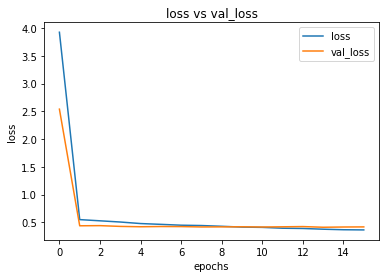

In [ ]:
plot_loss('training_7_',3)

**Best performing model with val score of 0.41**

**Testing best model on random samples from validation set**

In [7]:
def predict_breed(model,height,width):
    '''This function predicts outcomes from given model for 
    randomly selected 20 values from validation set'''


    breed_names = pd.Series([label_enc.classes_[np.argmax(i)] for i in y_test],name='breed')

    breed_names
    X_test.columns
    dic = {
        'id':X_test['id'].values,
        'breed':breed_names
    }
    t = pd.DataFrame(dic)
    path = os.path.join(os.getcwd(),'train')
    random_val = t.sample(n=20)
    truth = random_val['breed'].values
    prediction = []
    for image in random_val['id'].values:
      img_path = os.path.join(path,image+'.jpg')
      
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      
      img = cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
      img = img/255.
      
      pred = model.predict(img[np.newaxis,:,:,:])
      prediction.append(label_enc.classes_[np.argmax(pred[0])])
      
    dic = {
        'truth':truth,
        'prediction':prediction
    }

    return pd.DataFrame(dic)







#predict_breed(base_model_7,400,400)






In [12]:
predict_breed(best_model,400,400)

,truth,prediction
0,chihuahua,chihuahua
1,bull_mastiff,bull_mastiff
2,tibetan_mastiff,tibetan_mastiff
3,toy_poodle,miniature_poodle
4,dhole,dhole
5,entlebucher,entlebucher
6,lakeland_terrier,lakeland_terrier
7,toy_poodle,toy_poodle
8,malinois,malinois
9,bull_mastiff,bull_mastiff


**Our Best model gave accuracy of 87.3 %. Can be seen from the random predictions of 20 data points our model predicted 17 of them correctly**

**Getting score on kaggle test dataset**

In [ ]:
from tqdm import tqdm

def kaggle_predict(model,height,width):
  '''This function returns models prediction for the unseen test data'''
  path = os.path.join(os.getcwd(),'test')
  images = sorted(os.listdir(path))
  prediction = []
  for image in tqdm(images):
      img_path = os.path.join(path,image)
      
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      
      img = cv2.resize(img,(height,width),interpolation=cv2.INTER_AREA)
      img = img/255.
      
      pred = model.predict(img[np.newaxis,:,:,:])
      prediction.append(pred[0])


  return np.array(prediction)


prediction = kaggle_predict(base_model_7,400,400)


100%|██████████| 10357/10357 [15:27<00:00, 11.17it/s]


array([[5.7632431e-05, 7.5528756e-06, 5.0547169e-06, ..., 3.5361929e-06,
        1.9421650e-05, 1.4211919e-05],
       [1.7341225e-05, 8.9433179e-06, 9.9272111e-06, ..., 1.8906805e-05,
        6.6498496e-06, 8.5007468e-06],
       [2.0789006e-05, 2.0667985e-05, 6.5780958e-05, ..., 3.1895193e-05,
        4.0083480e-05, 5.2803703e-06],
       ...,
       [3.1500076e-06, 1.5871698e-06, 2.6456275e-04, ..., 4.2970910e-06,
        1.2035983e-07, 5.3121639e-06],
       [3.9551698e-04, 7.1525565e-06, 9.3476610e-06, ..., 4.4384005e-06,
        2.5473195e-05, 1.9225747e-03],
       [1.0932947e-05, 1.7314800e-05, 4.4904191e-05, ..., 1.0115254e-04,
        1.0434197e-04, 1.6765913e-06]], dtype=float32)

In [ ]:
id = np.array([image.split('.')[0] for image in sorted(os.listdir('test'))])
df = pd.DataFrame()
df['id'] = id
for i,breed in enumerate(label_enc.classes_):
  df[breed] = prediction.T[i]
df.to_csv('submission.csv',index=False)

In [ ]:
sub = pd.read_csv('submission.csv')
sub

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000058,0.000008,0.000005,9.906555e-07,1.040381e-06,0.000004,0.000011,7.155309e-07,5.740656e-06,1.370599e-06,1.304370e-06,7.963478e-06,0.000015,6.293959e-03,2.938022e-06,0.000005,0.000010,2.369358e-06,1.184708e-06,7.923616e-06,8.519425e-06,2.135807e-05,0.000456,0.000009,3.223804e-05,0.000011,4.037192e-06,5.639711e-07,2.927140e-06,8.591499e-05,0.000019,1.151718e-05,1.054871e-05,0.000014,9.802330e-06,3.261498e-06,0.000001,3.254217e-07,0.000006,...,0.000001,9.875984e-07,4.407727e-06,1.627875e-05,0.000625,1.489870e-01,2.206596e-06,0.000920,0.000103,0.000008,0.000012,0.000003,1.687216e-05,0.000018,4.103304e-06,6.372800e-06,0.000003,0.000002,1.855621e-05,0.000017,0.001612,0.000006,0.000010,5.522067e-06,4.202442e-06,1.159784e-06,1.423812e-06,5.239871e-05,0.000015,3.968013e-05,2.306158e-05,0.000004,0.000010,0.000004,4.296118e-06,0.000002,7.176511e-06,0.000004,1.942165e-05,0.000014
1,00102ee9d8eb90812350685311fe5890,0.000017,0.000009,0.000010,2.792160e-06,9.852221e-06,0.000069,0.000004,9.939521e-05,9.187266e-06,4.023596e-06,7.187933e-06,1.839182e-06,0.000043,2.857311e-06,7.757088e-06,0.000014,0.000057,5.294757e-07,2.936887e-07,2.202533e-06,3.777030e-05,3.247897e-05,0.000036,0.000018,3.427044e-06,0.000021,2.370013e-05,4.107726e-06,3.248261e-06,1.925138e-05,0.002083,2.188325e-06,2.899624e-06,0.000084,2.432179e-06,1.072875e-05,0.000024,6.913853e-06,0.000043,...,0.000243,4.766973e-04,3.831104e-06,1.213049e-05,0.000014,4.150196e-05,1.543306e-04,0.001141,0.000027,0.000034,0.000044,0.000013,2.412022e-06,0.000007,9.912960e-01,3.171121e-04,0.000040,0.000012,5.306022e-06,0.000046,0.000022,0.000268,0.000006,1.736886e-06,6.305846e-05,2.529248e-05,2.000223e-06,5.585015e-06,0.000030,1.839827e-05,9.345401e-06,0.000006,0.000024,0.000014,1.223328e-05,0.000003,7.661709e-04,0.000019,6.649850e-06,0.000009
2,0012a730dfa437f5f3613fb75efcd4ce,0.000021,0.000021,0.000066,9.395932e-04,7.321203e-06,0.000038,0.000010,8.486202e-06,6.703053e-04,9.227834e-05,2.606004e-05,8.762003e-05,0.000115,7.593266e-04,1.748265e-03,0.000180,0.000027,1.193940e-05,1.334828e-04,9.683116e-07,5.414713e-06,3.034763e-05,0.000025,0.000090,1.354243e-02,0.000011,1.111898e-05,4.007797e-05,1.560796e-04,8.943454e-05,0.000035,4.596595e-04,4.233107e-03,0.000041,1.280256e-05,5.494834e-06,0.000042,5.833755e-06,0.000009,...,0.000023,9.490722e-07,8.117071e-05,3.946449e-04,0.000013,7.897653e-05,8.643223e-07,0.000021,0.000042,0.000651,0.000201,0.000011,9.618196e-05,0.003952,7.327895e-06,4.797746e-06,0.000031,0.000205,4.650510e-05,0.000039,0.000013,0.000005,0.000014,5.100168e-05,1.530652e-05,3.114401e-05,3.147239e-05,3.771323e-05,0.000010,9.288750e-06,1.751912e-05,0.000002,0.001145,0.000135,4.664577e-04,0.043982,2.187267e-05,0.000032,4.008348e-05,0.000005
3,001510bc8570bbeee98c8d80c8a95ec1,0.000220,0.000004,0.000004,5.398814e-06,2.676905e-06,0.000353,0.000003,3.831373e-05,1.3387

**The score for model on the test dataset was 0.44641**

**Post training EDA**

In [10]:
#getting our best model
best_model = inception_resnet_model((400,400,3),0.3)

219070464/219055592 [==============================] - 6s 0us/step


In [15]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 11, 11, 1536)     54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               6

In [11]:
#loading weights
best_model_wts = os.path.join(os.getcwd(), 'drive','MyDrive', 'dog_inception_resnet_4')
best_model.load_weights(best_model_wts)

In [19]:
opt = Adam(0.0001)
best_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
best_model.fit(train_dataloader,epochs = 3,steps_per_epoch = len(train_dataloader),
               validation_data=test_dataloader)

Epoch 1/3
287/287 [==============================] - 192s 638ms/step - loss: 0.5310 - accuracy: 0.8350 - val_loss: 0.3888 - val_accuracy: 0.8790
Epoch 2/3
287/287 [==============================] - 184s 641ms/step - loss: 0.5123 - accuracy: 0.8414 - val_loss: 0.3856 - val_accuracy: 0.8770
Epoch 3/3
287/287 [==============================] - 184s 642ms/step - loss: 0.4850 - accuracy: 0.8517 - val_loss: 0.3826 - val_accuracy: 0.8740


In [13]:
#getting actual breed names
actual = [label_enc.classes_[np.argmax(i)] for i in y_test]
actual

['collie',
 'irish_wolfhound',
 'norwegian_elkhound',
 'lakeland_terrier',
 'norwegian_elkhound',
 'whippet',
 'soft-coated_wheaten_terrier',
 'newfoundland',
 'black-and-tan_coonhound',
 'sussex_spaniel',
 'doberman',
 'old_english_sheepdog',
 'irish_setter',
 'toy_terrier',
 'miniature_pinscher',
 'bernese_mountain_dog',
 'miniature_poodle',
 'pekinese',
 'saluki',
 'maltese_dog',
 'pembroke',
 'appenzeller',
 'kelpie',
 'norwegian_elkhound',
 'papillon',
 'kelpie',
 'toy_terrier',
 'collie',
 'weimaraner',
 'pug',
 'flat-coated_retriever',
 'german_shepherd',
 'great_pyrenees',
 'great_dane',
 'irish_water_spaniel',
 'wire-haired_fox_terrier',
 'kerry_blue_terrier',
 'bluetick',
 'blenheim_spaniel',
 'tibetan_mastiff',
 'bluetick',
 'scottish_deerhound',
 'papillon',
 'english_foxhound',
 'collie',
 'great_pyrenees',
 'bernese_mountain_dog',
 'brittany_spaniel',
 'standard_poodle',
 'shetland_sheepdog',
 'cairn',
 'tibetan_mastiff',
 'african_hunting_dog',
 'shih-tzu',
 'west_highla

In [14]:
#getting the predictions for validation data to see the confusion matrix
predictions = []
path = os.path.join(os.getcwd(),'train')

for image in X_test['id'].values:
  img_path = os.path.join(path,image+'.jpg')
      
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      
  img = cv2.resize(img,(400,400),interpolation=cv2.INTER_AREA)
  img = img/255.
      
  pred = best_model.predict(img[np.newaxis,:,:,:])
  predictions.append(label_enc.classes_[np.argmax(pred[0])])

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
classes = list(set(actual))
conf_mat = confusion_matrix(actual, predictions, labels=classes)

<AxesSubplot:>

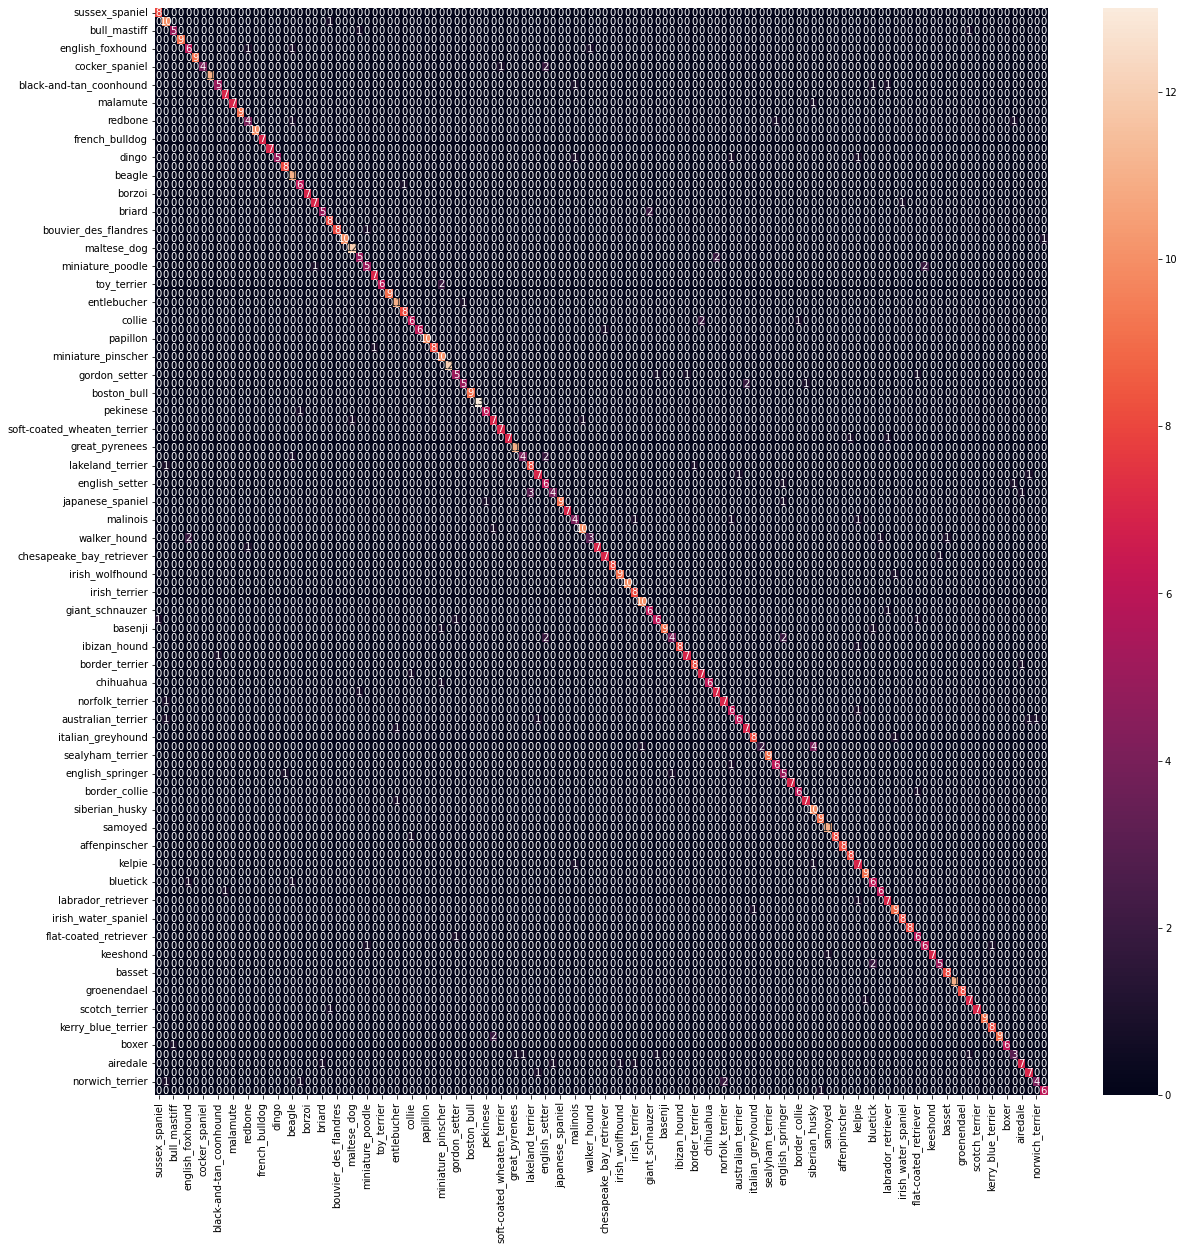

In [35]:
df_cm = pd.DataFrame(conf_mat, index = [i for i in classes],
                  columns = [i for i in classes])

plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

WE cannot see much from the matrix since our number of classes are 120 and it is becoming difficult to infer anything from the confusion matrix

We will hence try to divide our data into 3 parts good, medium and poor based on the accuracy values we get for the data.

In [45]:
pd.Series(actual)

0                  english_springer
1                              chow
2                    sussex_spaniel
3                             boxer
4                  blenheim_spaniel
                   ...             
1018    german_short-haired_pointer
1019               english_springer
1020               japanese_spaniel
1021                         basset
1022                   ibizan_hound
Length: 1023, dtype: object

In [15]:
X_test.reset_index(drop = True, inplace=True)

In [16]:
X_test

,id
0,2783d9ce4fef1ed1274d089be06d3d3b
1,f597a565d8b2e0d4ff1717a7d042472f
2,67701487906aebc113f3690152b62bdf
3,7afac31b992346ce894c3370f6e632d5
4,2ae2f3582606b45659a29dbff0311ac4
...,...
1018,6ca3ac32ec54672fe596b4835d546410
1019,e620a0807519a406a20dbe50ebeb1b1c
1020,3f609973f198def3b0ea1f12a3606a43
1021,bb725eb9bf95ceeb3d1fdf12b7b9dfb6


In [17]:
#combining validation data with actual class names
comb_test_data = pd.concat([X_test,pd.DataFrame(pd.Series(actual),columns=['breed'])],axis=1)
comb_test_data

,id,breed
0,2783d9ce4fef1ed1274d089be06d3d3b,collie
1,f597a565d8b2e0d4ff1717a7d042472f,irish_wolfhound
2,67701487906aebc113f3690152b62bdf,norwegian_elkhound
3,7afac31b992346ce894c3370f6e632d5,lakeland_terrier
4,2ae2f3582606b45659a29dbff0311ac4,norwegian_elkhound
...,...,...
1018,6ca3ac32ec54672fe596b4835d546410,west_highland_white_terrier
1019,e620a0807519a406a20dbe50ebeb1b1c,italian_greyhound
1020,3f609973f198def3b0ea1f12a3606a43,border_collie
1021,bb725eb9bf95ceeb3d1fdf12b7b9dfb6,chow


In [18]:
actual

['collie',
 'irish_wolfhound',
 'norwegian_elkhound',
 'lakeland_terrier',
 'norwegian_elkhound',
 'whippet',
 'soft-coated_wheaten_terrier',
 'newfoundland',
 'black-and-tan_coonhound',
 'sussex_spaniel',
 'doberman',
 'old_english_sheepdog',
 'irish_setter',
 'toy_terrier',
 'miniature_pinscher',
 'bernese_mountain_dog',
 'miniature_poodle',
 'pekinese',
 'saluki',
 'maltese_dog',
 'pembroke',
 'appenzeller',
 'kelpie',
 'norwegian_elkhound',
 'papillon',
 'kelpie',
 'toy_terrier',
 'collie',
 'weimaraner',
 'pug',
 'flat-coated_retriever',
 'german_shepherd',
 'great_pyrenees',
 'great_dane',
 'irish_water_spaniel',
 'wire-haired_fox_terrier',
 'kerry_blue_terrier',
 'bluetick',
 'blenheim_spaniel',
 'tibetan_mastiff',
 'bluetick',
 'scottish_deerhound',
 'papillon',
 'english_foxhound',
 'collie',
 'great_pyrenees',
 'bernese_mountain_dog',
 'brittany_spaniel',
 'standard_poodle',
 'shetland_sheepdog',
 'cairn',
 'tibetan_mastiff',
 'african_hunting_dog',
 'shih-tzu',
 'west_highla

In [19]:
'''Dividing my test data into bad, medium, and good based on the accuracy values'''
from tqdm import tqdm

#getting all the breeds
classes = list(set(actual))
class_in_test = {}
#dictionary to store the accuracy value we get for a particular breed (breed:accuracy)
accuracy_class = {}

#gettting accuracy for each breed
for breed in tqdm(classes):
  class_in_test[breed] = 1
  breed_test_data = comb_test_data[comb_test_data['breed'] == breed]
  actual = [breed for i in range(len(breed_test_data))]

  predictions = []
  for img in breed_test_data['id'].values:
    img_path = os.path.join(os.getcwd(), 'train', img + '.jpg')
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      
    img = cv2.resize(img,(400,400),interpolation=cv2.INTER_AREA)
    img = img/255.
      
    pred = best_model.predict(img[np.newaxis,:,:,:])
    predictions.append(label_enc.classes_[np.argmax(pred[0])])

  accuracy = (len(list(filter(lambda x: x == breed, predictions)))/len(predictions))*100
  accuracy_class[breed] = accuracy



 

100%|██████████| 120/120 [01:38<00:00,  1.22it/s]


In [20]:
accuracy_class

{'affenpinscher': 100.0,
 'afghan_hound': 100.0,
 'african_hunting_dog': 100.0,
 'airedale': 81.81818181818183,
 'american_staffordshire_terrier': 85.71428571428571,
 'appenzeller': 62.5,
 'australian_terrier': 60.0,
 'basenji': 90.9090909090909,
 'basset': 100.0,
 'beagle': 100.0,
 'bedlington_terrier': 100.0,
 'bernese_mountain_dog': 100.0,
 'black-and-tan_coonhound': 75.0,
 'blenheim_spaniel': 90.0,
 'bloodhound': 87.5,
 'bluetick': 100.0,
 'border_collie': 100.0,
 'border_terrier': 100.0,
 'borzoi': 100.0,
 'boston_bull': 100.0,
 'bouvier_des_flandres': 88.88888888888889,
 'boxer': 100.0,
 'brabancon_griffon': 100.0,
 'briard': 71.42857142857143,
 'brittany_spaniel': 100.0,
 'bull_mastiff': 100.0,
 'cairn': 72.72727272727273,
 'cardigan': 87.5,
 'chesapeake_bay_retriever': 75.0,
 'chihuahua': 100.0,
 'chow': 100.0,
 'clumber': 87.5,
 'cocker_spaniel': 85.71428571428571,
 'collie': 66.66666666666666,
 'curly-coated_retriever': 100.0,
 'dandie_dinmont': 100.0,
 'dhole': 100.0,
 'ding

In [21]:
len(accuracy_class)

120

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Accuracy')

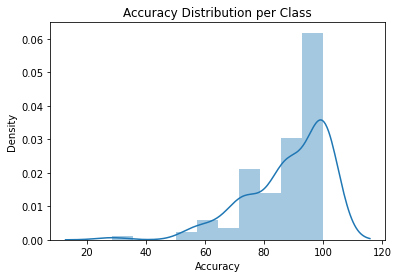

In [22]:
'''Distribution for accuracy for our test data'''
import seaborn as sns
sns.distplot(list(accuracy_class.values()))
plt.title('Accuracy Distribution per Class')
plt.xlabel('Accuracy')

we can define the ranges for our data to categorize them into good , medium and poor.
if accuracy for a breed lies between 85 to 100 we can put that datapoint into good category.
if accuracy for a breed lies between 65 to 85 we can put that datapoint into medium category.
if accuracy for a breed is less than 65 then we can put that datapoint into poor category.

In [23]:
'''Dividing our data into good, average and poor based on accuracy values'''
good = {} 
average = {} 
poor = {}

for breed,acc in accuracy_class.items():
    if(acc <= 65):
      poor[breed] = comb_test_data[comb_test_data['breed'] == breed]['id'].values
    elif(acc > 65 and acc <= 85):
      average[breed] = comb_test_data[comb_test_data['breed'] == breed]['id'].values
    else:
      good[breed] = comb_test_data[comb_test_data['breed'] == breed]['id'].values



In [24]:
len(good), len(average), len(poor)

(87, 25, 8)

there are 87 breeds which get high accuracy , 24 breeds with medium accuracy and 9 breeds with poor accuracy

**Poor data analysis**

In [25]:
for p_breed in poor.keys():
  print('Accuracy for {} in test data is {}'.format(p_breed, accuracy_class[p_breed]))

Accuracy for malinois in test data is 57.14285714285714
Accuracy for eskimo_dog in test data is 28.57142857142857
Accuracy for wire-haired_fox_terrier in test data is 62.5
Accuracy for walker_hound in test data is 57.14285714285714
Accuracy for appenzeller in test data is 62.5
Accuracy for silky_terrier in test data is 55.55555555555556
Accuracy for australian_terrier in test data is 60.0
Accuracy for rhodesian_ridgeback in test data is 55.55555555555556


In [27]:
'''eskimo dog analysis'''

def poor_analysis(breed):
    '''This function for a given breed gets the predictions by our model for the test data
    and returns the df with actual and predicted values'''
    
    poor_actual = [breed for b in poor[breed]]
    poor_ed_pred = []
    for image in poor[breed]:
      img_path = os.path.join(os.getcwd(), 'train' , image+'.jpg')
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
          
      img = cv2.resize(img,(400,400),interpolation=cv2.INTER_AREA)
      img = img/255.
          
      pred = best_model.predict(img[np.newaxis,:,:,:])
      poor_ed_pred.append(label_enc.classes_[np.argmax(pred[0])])

    ed_df = pd.DataFrame()
    ed_df['actual'] = poor_actual
    ed_df['predictions'] = poor_ed_pred
    return ed_df


In [37]:
ed_df = poor_analysis('eskimo_dog')
ed_df

,actual,predictions
0,eskimo_dog,siberian_husky
1,eskimo_dog,eskimo_dog
2,eskimo_dog,eskimo_dog
3,eskimo_dog,malamute
4,eskimo_dog,siberian_husky
5,eskimo_dog,norwegian_elkhound
6,eskimo_dog,siberian_husky


eskimo dog is getting mixed with siberian husky most often

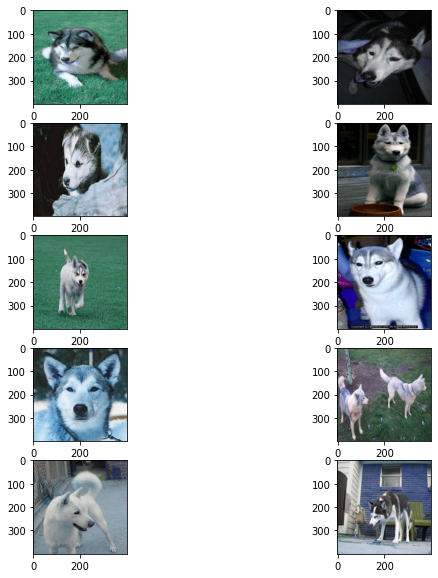

In [45]:
'''plotting some images of eskimo dog and siberian husky in our  dataset'''
ed_data = comb_test_data[comb_test_data['breed'] == 'eskimo_dog']
ed_data_sample = ed_data.sample(n = 5)
sh_data = comb_test_data[comb_test_data['breed'] == 'siberian_husky']
sh_data_sample = sh_data.sample(n = 5)
fig, axes = plt.subplots(nrows= 5, ncols= 2, figsize=(10,10))

row = 0
for i in range(5):
  col = 0
  ed_img = ed_data_sample.iloc[i]['id']
  sh_img = sh_data_sample.iloc[i]['id']
  ed_img_path = os.path.join(os.getcwd(), 'train' , ed_img+'.jpg')
  sh_img_path = os.path.join(os.getcwd(), 'train' , sh_img+'.jpg')


  ed_img = cv2.imread(ed_img_path, cv2.IMREAD_UNCHANGED)
          
  ed_img = cv2.resize(ed_img,(400,400),interpolation=cv2.INTER_AREA)

  sh_img = cv2.imread(sh_img_path, cv2.IMREAD_UNCHANGED)
          
  sh_img = cv2.resize(sh_img,(400,400),interpolation=cv2.INTER_AREA)

  axes[row,col].imshow(ed_img)
  axes[row,col+1].imshow(sh_img)
  row += 1


eskimo dog(left) looks quite same as eskimo husky(right) and may be thats why the model is confused between them

In [28]:
'''silky_terrier analysis'''
st_df = poor_analysis('silky_terrier')
st_df

,actual,predictions
0,silky_terrier,silky_terrier
1,silky_terrier,australian_terrier
2,silky_terrier,yorkshire_terrier
3,silky_terrier,silky_terrier
4,silky_terrier,lhasa
5,silky_terrier,silky_terrier
6,silky_terrier,yorkshire_terrier
7,silky_terrier,silky_terrier
8,silky_terrier,silky_terrier


silky terrier gets confused with australian terrier and yorkshire terrier

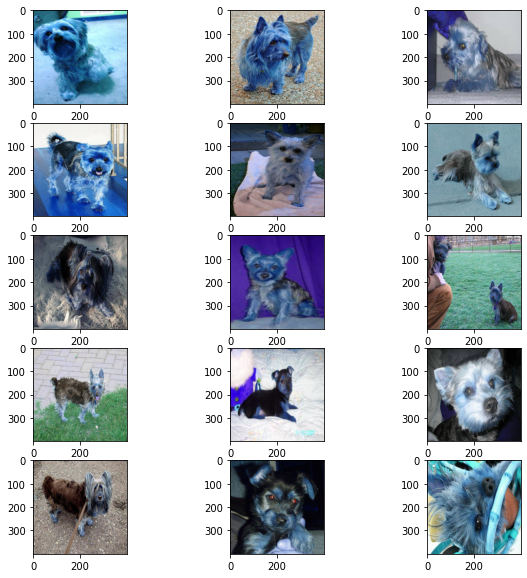

In [30]:
'''plotting some images of silky terrier, australian terrier and yorkshire terrier in our  dataset'''
st_data = comb_test_data[comb_test_data['breed'] == 'silky_terrier']
st_data_sample = st_data.sample(n = 5)
at_data = comb_test_data[comb_test_data['breed'] == 'australian_terrier']
at_data_sample = at_data.sample(n = 5)
yt_data = comb_test_data[comb_test_data['breed'] == 'yorkshire_terrier']
yt_data_sample = yt_data.sample(n = 5)
fig, axes = plt.subplots(nrows= 5, ncols= 3, figsize=(10,10))

row = 0
for i in range(5):
  col = 0
  st_img = st_data_sample.iloc[i]['id']
  at_img = at_data_sample.iloc[i]['id']
  yt_img = yt_data_sample.iloc[i]['id']
  st_img_path = os.path.join(os.getcwd(), 'train' , st_img+'.jpg')
  at_img_path = os.path.join(os.getcwd(), 'train' , at_img+'.jpg')
  yt_img_path = os.path.join(os.getcwd(), 'train' , yt_img+'.jpg')


  st_img = cv2.imread(st_img_path, cv2.IMREAD_UNCHANGED)
          
  st_img = cv2.resize(st_img,(400,400),interpolation=cv2.INTER_AREA)

  at_img = cv2.imread(at_img_path, cv2.IMREAD_UNCHANGED)
          
  at_img = cv2.resize(at_img,(400,400),interpolation=cv2.INTER_AREA)

  yt_img = cv2.imread(yt_img_path, cv2.IMREAD_UNCHANGED)
          
  yt_img = cv2.resize(yt_img,(400,400),interpolation=cv2.INTER_AREA)

  axes[row,col].imshow(st_img)
  axes[row,col+1].imshow(at_img)
  axes[row,col+2].imshow(yt_img)
  row += 1

we can see that our model is also confused between different terriers breed, probably because they look quite similar and is really hard to seperate them.
The above plot shows silky terrier, australian terrier and yorkshire terrier from left to right.

In [32]:
'''malinois analysis'''

m_df = poor_analysis('malinois')
m_df

,actual,predictions
0,malinois,malinois
1,malinois,malinois
2,malinois,malinois
3,malinois,malinois
4,malinois,german_shepherd
5,malinois,kelpie
6,malinois,kelpie


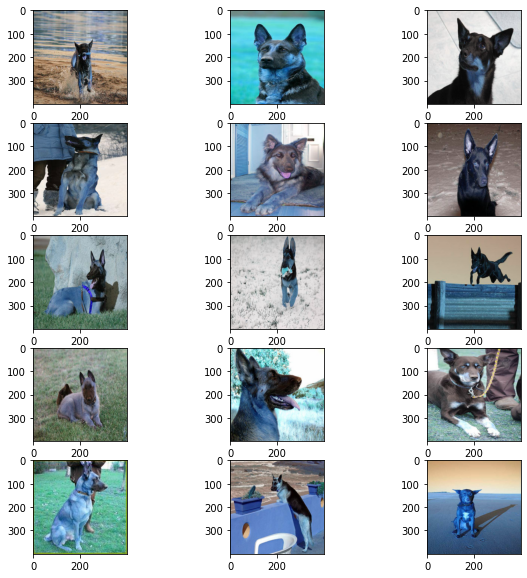

In [33]:
'''plotting some images of malinois, german shepherd and kelpie in our  dataset'''
st_data = comb_test_data[comb_test_data['breed'] == 'malinois']
st_data_sample = st_data.sample(n = 5)
at_data = comb_test_data[comb_test_data['breed'] == 'german_shepherd']
at_data_sample = at_data.sample(n = 5)
yt_data = comb_test_data[comb_test_data['breed'] == 'kelpie']
yt_data_sample = yt_data.sample(n = 5)
fig, axes = plt.subplots(nrows= 5, ncols= 3, figsize=(10,10))

row = 0
for i in range(5):
  col = 0
  st_img = st_data_sample.iloc[i]['id']
  at_img = at_data_sample.iloc[i]['id']
  yt_img = yt_data_sample.iloc[i]['id']
  st_img_path = os.path.join(os.getcwd(), 'train' , st_img+'.jpg')
  at_img_path = os.path.join(os.getcwd(), 'train' , at_img+'.jpg')
  yt_img_path = os.path.join(os.getcwd(), 'train' , yt_img+'.jpg')


  st_img = cv2.imread(st_img_path, cv2.IMREAD_UNCHANGED)
          
  st_img = cv2.resize(st_img,(400,400),interpolation=cv2.INTER_AREA)

  at_img = cv2.imread(at_img_path, cv2.IMREAD_UNCHANGED)
          
  at_img = cv2.resize(at_img,(400,400),interpolation=cv2.INTER_AREA)

  yt_img = cv2.imread(yt_img_path, cv2.IMREAD_UNCHANGED)
          
  yt_img = cv2.resize(yt_img,(400,400),interpolation=cv2.INTER_AREA)

  axes[row,col].imshow(st_img)
  axes[row,col+1].imshow(at_img)
  axes[row,col+2].imshow(yt_img)
  row += 1

we can see that our model is also confused between different similar loking  breed, probably because they look quite similar and is really hard to seperate them.
The above plot shows malinois, german shepherd and kelpie from left to right.

Looking at the poor labeled data we can say that those are breeds of dogs which are generally quite difficult to differentiate because they look quite similar in size shape and color. Our model has not learnt much about differentiating them, probably increasing the data size for these breeds and training our model again would help our cause.